<a href="https://colab.research.google.com/github/amalvarezme/AnaliticaDatos/blob/master/TFAgents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TF-Agents para jugar Breakout

-- La librería de aprendizaje por refuerzo de tensorflow
[tfagents](https://www.tensorflow.org/agents?hl=es-419)

-- Se utilizará TF-Agents para crear una agente que aprenderá a jugar [Breakout](https://elgoog.im/breakout/). 


-- Se utilizará el algoritmo Deep Q-Learning.

-- TF-Agents permite utilizar wrappers y redes DQN convencionales, como las utilizadas en el cartpole, y otras más sofisticadas!


## Instalación y configuracíon requerida

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    !pip install -q -U tf-agents pyvirtualdisplay gym[atari,box2d]
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [53.1 kB]
Hit:12 http://ppa.launchpad.net/cran/

## TF-Agents Environments

-- El ambiente de TF agents, entre muchas de sus funcionalidades, actua como wrapper del OpenAI gym.

-- Se creará un escenario del juego Breakout

In [4]:
tf.random.set_seed(42)
np.random.seed(42)

In [10]:
from tf_agents.environments import suite_gym

env = suite_gym.load("Breakout-v4") # se puede fijar el discount= xxx (discount factor)
env

In [11]:
env.gym

-- A diferencia del OpenAI, tf agents tiene un método `reset()` que no devuelve una observación, devuelve un `TimeStep` que actúa como wrapper de la observación.


In [12]:
env.seed(42)
env.reset()

TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

-- El método `step()` también devuelve un objeto `TimeStep`

In [13]:
env.step(1) # Fire

TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

-- El atributo `step_type` es 0 para el primer time step del episodio, 1 para time steps intermedios y 2 para el step final.

-- Se puede llamar al método `is_last()` del `TimeStep` para saber si es el paso final.

-- `discount` indica el discount factor que se usa en cada paso. (Se puede fijar cuando se carga el ambiente)

Saving figure breakout_plot


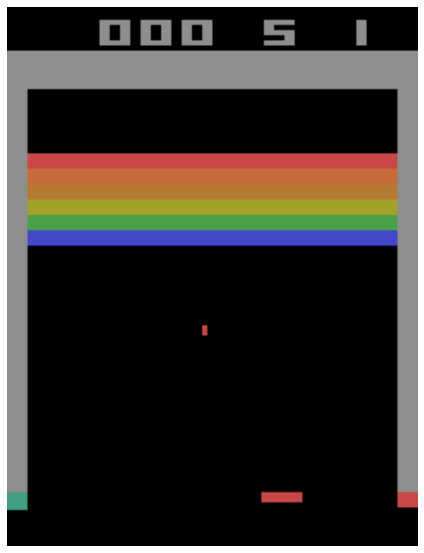

In [14]:
img = env.render(mode="rgb_array")

plt.figure(figsize=(6, 8))
plt.imshow(img)
plt.axis("off")
save_fig("breakout_plot")
plt.show()

In [15]:
env.current_time_step()

TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

## Especificaciones del ambiente (escenario)

-- TF agents provee especificaciones de las observaciones, acciones, y time steps.

In [16]:
env.observation_spec()

BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)

In [17]:
env.action_spec()

BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)

In [18]:
env.time_step_spec()

TimeStep(step_type=ArraySpec(shape=(), dtype=dtype('int32'), name='step_type'), reward=ArraySpec(shape=(), dtype=dtype('float32'), name='reward'), discount=BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0), observation=BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255))

-- En este caso las observaciones son frames (imágenes) de la pantalla del Atari, en numpy arrays de [210,160,3].



In [19]:
env.gym.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

-- En este caso tenemos cuatro acciones disponibles.

-- La representación de las observaciones (imagenes), deben ser submuestreadas y convertidas a escala de grises para preservar memoría RAM.

-- Para ello se puede utilizar un *environment wrapper*.

## Environment Wrappers y preprocesamiento en Atari



In [28]:
import tf_agents.environments.wrappers # lista de wrappers disponibles

for name in dir(tf_agents.environments.wrappers):
    obj = getattr(tf_agents.environments.wrappers, name)
    if hasattr(obj, "__base__") and issubclass(obj, tf_agents.environments.wrappers.PyEnvironmentBaseWrapper):
        print("{:27s} {}".format(name, obj.__doc__.split("\n")[0]))

ActionClipWrapper           Wraps an environment and clips actions to spec before applying.
ActionDiscretizeWrapper     Wraps an environment with continuous actions and discretizes them.
ActionOffsetWrapper         Offsets actions to be zero-based.
ActionRepeat                Repeates actions over n-steps while acummulating the received reward.
FlattenObservationsWrapper  Wraps an environment and flattens nested multi-dimensional observations.
GoalReplayEnvWrapper        Adds a goal to the observation, used for HER (Hindsight Experience Replay).
HistoryWrapper              Adds observation and action history to the environment's observations.
ObservationFilterWrapper    Filters observations based on an array of indexes.
OneHotActionWrapper         Converts discrete action to one_hot format.
PerformanceProfiler         End episodes after specified number of steps.
PyEnvironmentBaseWrapper    PyEnvironment wrapper forwards calls to the given environment.
RunStats                    Wrapp

In [29]:
from tf_agents.environments.wrappers import ActionRepeat

repeating_env = ActionRepeat(env, times=4) # se repite la accion 4 veces
repeating_env

In [30]:
repeating_env.unwrapped # el tf agent contiene el escenario de Atari

-- El método `suite_gym.load()` crea un escenario y codifica (wrap) para TF-Agents environment wrappers y Gym environment wrappers.

-- Se creará un código que construye un ambiente BreakOut y correrá por un máximo de 10.000 pasos durante cada episodio, y cada acción se repite 4 veces:

In [33]:
from functools import partial
from gym.wrappers import TimeLimit

limited_repeating_env = suite_gym.load(
    "Breakout-v4",
    gym_env_wrappers=[partial(TimeLimit, max_episode_steps=10000)],
    env_wrappers=[partial(ActionRepeat, times=4)],
)

In [34]:
limited_repeating_env

In [35]:
limited_repeating_env.unwrapped

-- En la mayoría de ocasiones se requiere aplicar algunas etapas de preprocesamiento.

-- Tf agents proporciona una serie de wrappers desde el  `AtariPreprocessing`, que incluye:
  -`Grayscale and downsampling`: se muestrea a 84 x 84 pixeles por defecto.
  - `Max pooling`: los últimos dos frames se filtran con max pooling de 1 x 1.
  - `Frame skipping`: el agente solo ve cada $n$ frames (por defecto 4).
  - `End of life lost`: el episodio termina justo cuando se pierde una vida.

-- Se creará un escenario Atari Breakout y se le aplicarán algunas etapas de preproceso.

-- Por defecto Atari aplca frame skipping y max pooling, or ende se llamará la variante `BreakoutNoFrameskip-v4`.

-- Para codificar la velocidad, utilizaremos el `FrameStack4`, el cual retorna una serie de cuatro frames sobre la dimensión de canales de la imagen.

**Nota:** Breakout requiere que el usuario presione el botón FIRE para iniciar o al perder una vida. El agente puede tardar mucho en aprender esto, dado que puede entender que es una forma de perder rápido. Para acelerar el entrenamiento se creará la subclase del `AtariPreprocessing` wrapper, llamada `AtariPreprocessingWithAutoFire`, que presiona FIRE (i.e., plays action 1) automáticamente al empezar el juego o perder una vida.

In [37]:
from tf_agents.environments import suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

max_episode_steps = 27000 # 
environment_name = "BreakoutNoFrameskip-v4"

class AtariPreprocessingWithAutoFire(AtariPreprocessing):
    def reset(self, **kwargs):
        obs = super().reset(**kwargs)
        super().step(1) # FIRE to start
        return obs
    def step(self, action):
        lives_before_action = self.ale.lives()
        obs, rewards, done, info = super().step(action)
        if self.ale.lives() < lives_before_action and not done:
            super().step(1) # FIRE to start after life lost
        return obs, rewards, done, info

env = suite_atari.load(
    environment_name,
    max_episode_steps=max_episode_steps,
    gym_env_wrappers=[AtariPreprocessingWithAutoFire, FrameStack4])

In [38]:
env

-- Juguemos unos cuantos pasos:

In [39]:
env.seed(42)
env.reset()
for _ in range(4):
    time_step = env.step(3) # LEFT

In [40]:
def plot_observation(obs):
    # Since there are only 3 color channels, you cannot display 4 frames
    # with one primary color per frame. So this code computes the delta between
    # the current frame and the mean of the other frames, and it adds this delta
    # to the red and blue channels to get a pink color for the current frame.
    obs = obs.astype(np.float32)
    img = obs[..., :3]
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1), 0.)
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta
    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis("off")

Saving figure preprocessed_breakout_plot


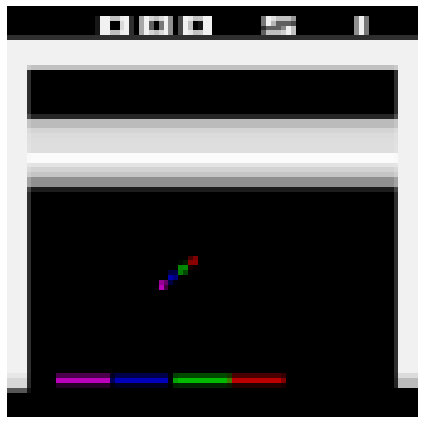

In [41]:
plt.figure(figsize=(6, 6))
plot_observation(time_step.observation)
save_fig("preprocessed_breakout_plot")
plt.show()

-- Ahora construiremos el Python environment a TF environment:

In [42]:
from tf_agents.environments.tf_py_environment import TFPyEnvironment

tf_env = TFPyEnvironment(env)

-- Lo anterior permitirá que el escenario sea compatible con un grafo computacional de TensorFlow.

-- Ya se tiene un escenario de Breakout, con el preprocesamiento requerido y que sea compatible con TensorFlow.

-- Podemos entrenar una DQN y otros componentes.

